In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pprint import pprint
from operator import truediv
from __future__ import division

plt.style.use('ggplot') # black-and-white friendly

graphInfo = {
    "p2p-Gnutella08": (6301, 20777),
    "ca-HepTh": (9877, 25973),
    "amazon0601": (403394, 2443408),
    "wiki-Talk": (2394385, 4659565),
    "as-skitter": (1696415, 11095298),
    "soc-LiveJournal1": (4847571, 43369619),
    "indochina-2004": (7414768, 153487303),
    "cit-Patents": (3774768, 16518947),
    "ca-HepPh": (12008, 118521),
    "email-Enron": (36692, 183831),
    "soc-Epinions1": (75879, 405740),
    "com-dblp": (317080, 1049866),
    "soc-Slashdot0902": (82168, 504230),
    "roadNet-PA": (1088092, 1541898),
    "flickrEdges": (105938,2316948),
    "graph500-scale18-ef16": (174147, 3800348),
    "graph500-scale19-ef16": (335318, 7729675),
    "graph500-scale20-ef16": (645820, 15680861),
    "graph500-scale21-ef16": (1243072, 31731650),
    "graph500-scale22-ef16": (2393285, 64097004),
    "graph500-scale22-ef16": (4606314, 129250705),
}

GRAPHS = ["p2p-Gnutella08","ca-HepTh","ca-HepPh","email-Enron","soc-Epinions1", "cit-HepPh",
          "soc-Slashdot0902","roadNet-PA","flickrEdges","amazon0601","cit-Patents",
          "graph500-scale18-ef16","graph500-scale19-ef16","graph500-scale20-ef16",
          "graph500-scale21-ef16","graph500-scale22-ef16","graph500-scale23-ef16"]

CUS1 = "cuSTINGER-Iterative"
CUS2 = "cuSTINGER-Delta"
WC = "Wang-Cheng"

markers = {
    "Python": 'o',
    "Octave": '*',
    "Julia": '^',
    "Graphulo": 's',
    WC: 'D',
    CUS1: '+',
    CUS2: 'x',
}

POWER = {
    "Python": 286,
    "Octave": 286,
    "Julia": 286,
    CUS1: 350,
    CUS2: 350,
}

"""
Filters relevant parameters and data from results file into a dictionary.
Processes results *as is*; doesn't check for missing data, etc. 
"""
def getResults(fPath):
    app_info = dict()
    with open(fPath, 'r') as f:
        curr_graph = None
        for line in f:
            if "graph=" in line:
                g_info = line.split(',')
                graph = g_info[0].split("=")[1].strip()
                if (graph not in app_info.keys()):
                    app_info[graph] = dict()
                curr_graph = graph
                if len(g_info) > 1: # k-max won't have k= header
                    k = int(g_info[1].split("=")[1].strip())
            if "k=" in line and ":" in line:
                t_split = line.split(":")
                k = int(t_split[0].split("=")[1])
                t = float(t_split[1].strip())
                app_info[curr_graph]["k"] = (k,t)
            if "k-iter=" in line and ":" in line:
                t_split = line.split(":")
                k_iter = int(t_split[0].split("=")[1])
                t_iter = float(t_split[1].strip())
                if "k-iter" not in app_info[curr_graph].keys():
                    app_info[curr_graph]["k-iter"] = []
                app_info[curr_graph]["k-iter"].append(t_iter)
            if "elapsed time" in line:
                s = line.split(":")
                t_split = s[1].strip().split()
                t = float(t_split[0].strip())
                app_info[curr_graph]["k"] = (k,t)
                
#     pprint(app_info)
    return app_info
        
def speedups(paths, apps, graphs):
    all_info = [getResults(p) for p in paths]
    all_times = []
    for i,app in enumerate(apps):
        app_info = all_info[i]
        graph_times = []
        for g in graphs:
            g_info = app_info.get(g, None)
            if g_info:
                k_info = g_info.get("k", None)
                if k_info:
                    graph_times.append(k_info[1])
                else:
                    graph_times.append(np.nan)
            else:
                graph_times.append(np.nan)
        all_times.append(graph_times)
    
    pprint(all_times)
    
    all_speedups = []
    baseline = all_times[0]
    for i in range(len(all_times)):
        curr_times = all_times[i]
        speedups = []
        for t0, t1 in zip(baseline, curr_times):
            speedups.append(t0/t1)
        all_speedups.append(speedups)
    return all_speedups
        

def plotKCompareScatter(paths, apps, graphs, title=None, savePath=None):
    all_info = [getResults(p) for p in paths]
    all_times = []
    for i,app in enumerate(apps):
        app_info = all_info[i]
        graph_times = []
        for g in graphs:
            g_info = app_info.get(g, None)
            if g_info:
                k_info = g_info.get("k", None)
                if k_info:
                    graph_times.append(k_info[1])
                else:
                    graph_times.append(np.nan)
            else:
                graph_times.append(np.nan)
        all_times.append(graph_times)
        
    x_vals = [graphInfo[g][1] if g in graphInfo.keys() else np.nan for g in graphs]
    scatterPlot(all_times, x_vals, apps, title, xLabel="|E|", yLabel="Runtime (s)", logx=True, logy=True)
    if savePath:
        plt.savefig(savePath)
        
def plotKCompareEnergy(paths, apps, graphs, title=None, savePath=None):
    all_info = [getResults(p) for p in paths]
    all_times = []
    for i,app in enumerate(apps):
        app_info = all_info[i]
        graph_times = []
        for g in graphs:
            g_info = app_info.get(g, None)
            if g_info:
                k_info = g_info.get("k", None)
                if k_info:
                    graph_times.append(POWER[app]*k_info[1])
                else:
                    graph_times.append(np.nan)
            else:
                graph_times.append(np.nan)
        all_times.append(graph_times)
        
    x_vals = [graphInfo[g][1] if g in graphInfo.keys() else np.nan for g in graphs]
    scatterPlot(all_times, x_vals, apps, title, xLabel="|E|", yLabel="Total Energy (J)", logx=True, logy=True)
    if savePath:
        plt.savefig(savePath)

def plotKIterScatter(paths, apps, graph, title=None, savePath=None):
    all_info = [getResults(p) for p in paths]
    all_times = []
    for i,app in enumerate(apps):
        app_info = all_info[i]
        g_info = app_info.get(graph, None)
        if g_info:
            k = int(g_info["k"][0])
            kIterTimes = g_info["k-iter"]
            all_times.append(kIterTimes)
    
#     pprint(all_times)
    x_vals = list(range(3, k+2))
    scatterPlot(all_times, x_vals, apps, title, xLabel="k-iter", yLabel="Runtime (s)", logy=True)
    if savePath:
        plt.savefig(savePath)

        
def scatterPlot(scatter_info, x_vals, series, title, xLabel="Benchmark", yLabel="Speedup", logx=False, logy=False):
    plt.figure(figsize=(15, 10), dpi=600)
    ax = plt.subplot()
    if logy:
        ax.set_yscale('log', basey=10)
    if logx: 
        ax.set_xscale('log', basex=10)
    for i, values_list in enumerate(scatter_info): # missing marker
        ax.scatter(x_vals, scatter_info[i], s=170, label=series[i], marker=markers[series[i]])

    ax.set_xlabel(xLabel, fontweight='bold', fontsize=28)
    ax.set_ylabel(yLabel, fontweight='bold', fontsize=28)
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
    if title:
        ax.set_title(title, fontweight='bold')
    ax.legend(loc=2,prop={'size':16})
    

def barChart(bar_info, xLabels, bar_labels, title, xLabel="Benchmark", yLabel="Speedup", logy=False):
    N = len(bar_info[0])
    ind = np.arange(N)
    margin=.15
    width=(1-margin)/len(bar_info)

    plt.figure(figsize=(15, 10), dpi=600)
    ax = plt.subplot()
    if logy:
        ax.set_yscale('log', basey=10)
    for i, values_list in enumerate(bar_info):
        ax.bar(ind+i*width, values_list, width, label=xLabels[i], color=cm.plasma(1.*i/len(bar_info)))

    ax.set_xlabel(xLabel, fontweight='bold')
    ax.set_ylabel(yLabel, fontweight='bold')
    if title:
        ax.set_title(title, fontweight='bold')
    ax.set_xticks(ind + (len(bar_info)/2)*width - (width/2), minor=False)
    ax.set_xticklabels(bar_labels)
    ax.legend(loc='best')


In [33]:
results = ["../results/python-k4-062717.out",
           "../results/matlab-k4-062717.out",
           "../results/julia-k4-062717.out", 
          "../results/custinger-static-k4-062317.out",
          "../results/custinger-dynamic-k4-062317.out"]
benchmarks = ["Python", "Octave", "Julia", CUS1, CUS2]
ratios = speedups(results, benchmarks, GRAPHS)
pprint(ratios)

[[0.969116,
  0.5802039999999999,
  6.895773,
  15.077577999999999,
  60.363693,
  nan,
  71.67172599999999,
  70.56193099999999,
  680.5322319999999,
  82.06286399999999,
  1702.300318,
  6034.410846,
  25418.661392,
  nan,
  nan,
  nan,
  nan],
 [0.040428,
  0.098076,
  3.8283,
  7.213127,
  26.833824,
  19.574875,
  25.551811,
  0.896179,
  nan,
  39.337944,
  251.415924,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [1.688389,
  2.254628,
  18.128335,
  39.948868,
  362.294934,
  291.745414,
  825.939878,
  1244.406887,
  7392.770537,
  10609.255727,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [0.137263,
  0.00966685,
  0.0307077,
  0.201674,
  0.450369,
  0.0881133,
  17.0251,
  1.99877,
  4.59415,
  2.55168,
  21.6582,
  40.7565,
  106.724,
  303.246,
  771.919,
  2180.05,
  5576.45],
 [0.00952531,
  0.00838822,
  0.025303,
  0.140059,
  0.187998,
  0.0465594,
  0.262478,
  0.0888012,
  1.28666,
  0.819588,
  1.06846,
  7.13066,
  18.0766,
  48.7621,
  118.572,
  301.367,
  

In [35]:
results = ["../results/python-maxk-062717.out",
           "../results/matlab-maxk-062717.out",
           "../results/julia-maxk-062717.out",
          "../results/custinger-static-maxk-062717.out",
          "../results/custinger-dynamic-maxk-062717.out"]
benchmarks = ["Python", "Octave", "Julia", CUS1, CUS2]
ratios = speedups(results, benchmarks, GRAPHS)
pprint(ratios)

[[2.0668699999999998,
  5.518549,
  279.84676,
  422.02705000000003,
  1664.286676,
  nan,
  1148.060608,
  90.503449,
  nan,
  824.011997,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [0.056641,
  0.260597,
  124.609909,
  79.194435,
  320.068825,
  144.731865,
  91.156754,
  1.141838,
  nan,
  124.018227,
  593.138695,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [1.728198,
  4.883207,
  1432.219322,
  1339.197763,
  8680.841865,
  7316.046918,
  4106.822981,
  1241.482169,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [0.0144216,
  0.0344003,
  1.62786,
  1.26733,
  3.98815,
  0.950048,
  1.25847,
  0.107333,
  140.052,
  1.3733,
  7.30945,
  1056.39,
  3245.96,
  9706.46,
  37395.6,
  nan,
  nan],
 [0.0159118,
  0.037711,
  1.61165,
  1.0394,
  2.26422,
  0.792325,
  1.25543,
  0.101445,
  41.8007,
  1.04925,
  5.81381,
  51.4589,
  103.003,
  210.537,
  469.712,
  1030.11,
  2500.46]]
[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  nan,
  1.0,
  1.0,
  nan,
  1.0,
  n

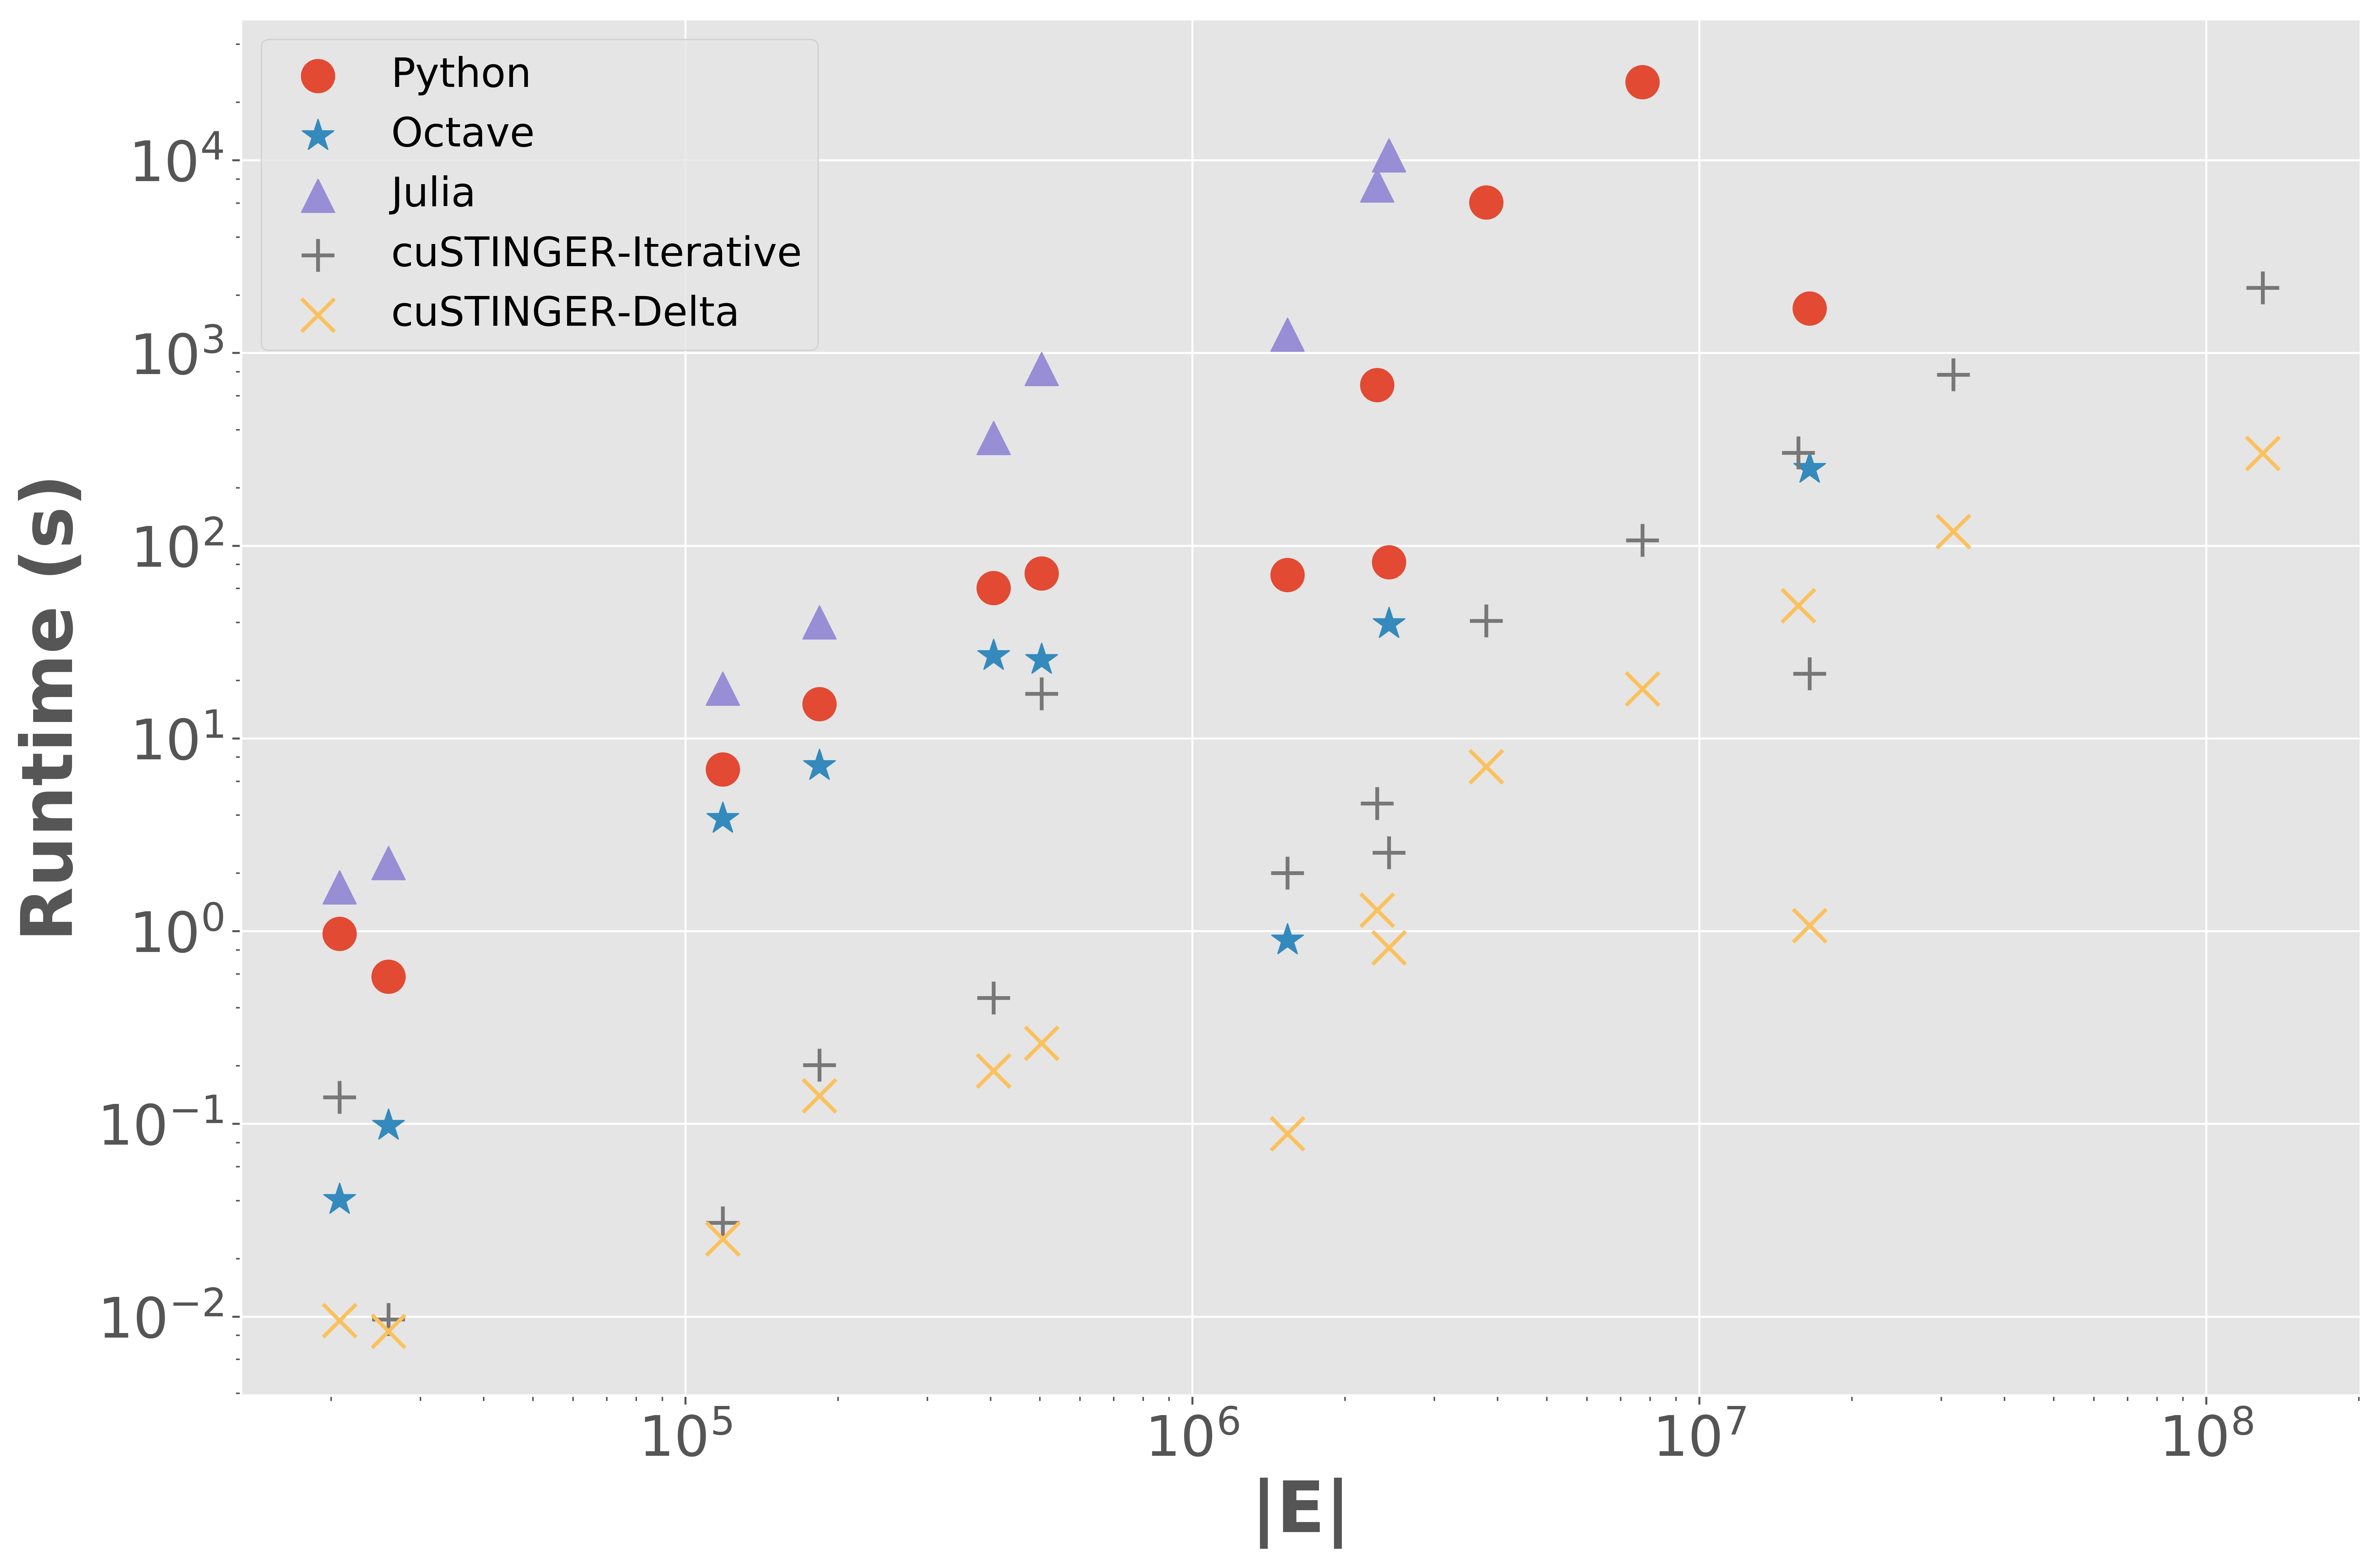

In [25]:
results = ["../results/python-k4-062717.out",
           "../results/matlab-k4-062717.out",
           "../results/julia-k4-062717.out", 
          "../results/custinger-static-k4-062317.out",
          "../results/custinger-dynamic-k4-062317.out"]
benchmarks = ["Python", "Octave", "Julia", CUS1, CUS2]
saveTo = "../analysis/k4-scatter-final.pdf"
plotKCompareScatter(results, benchmarks, GRAPHS, savePath=saveTo)

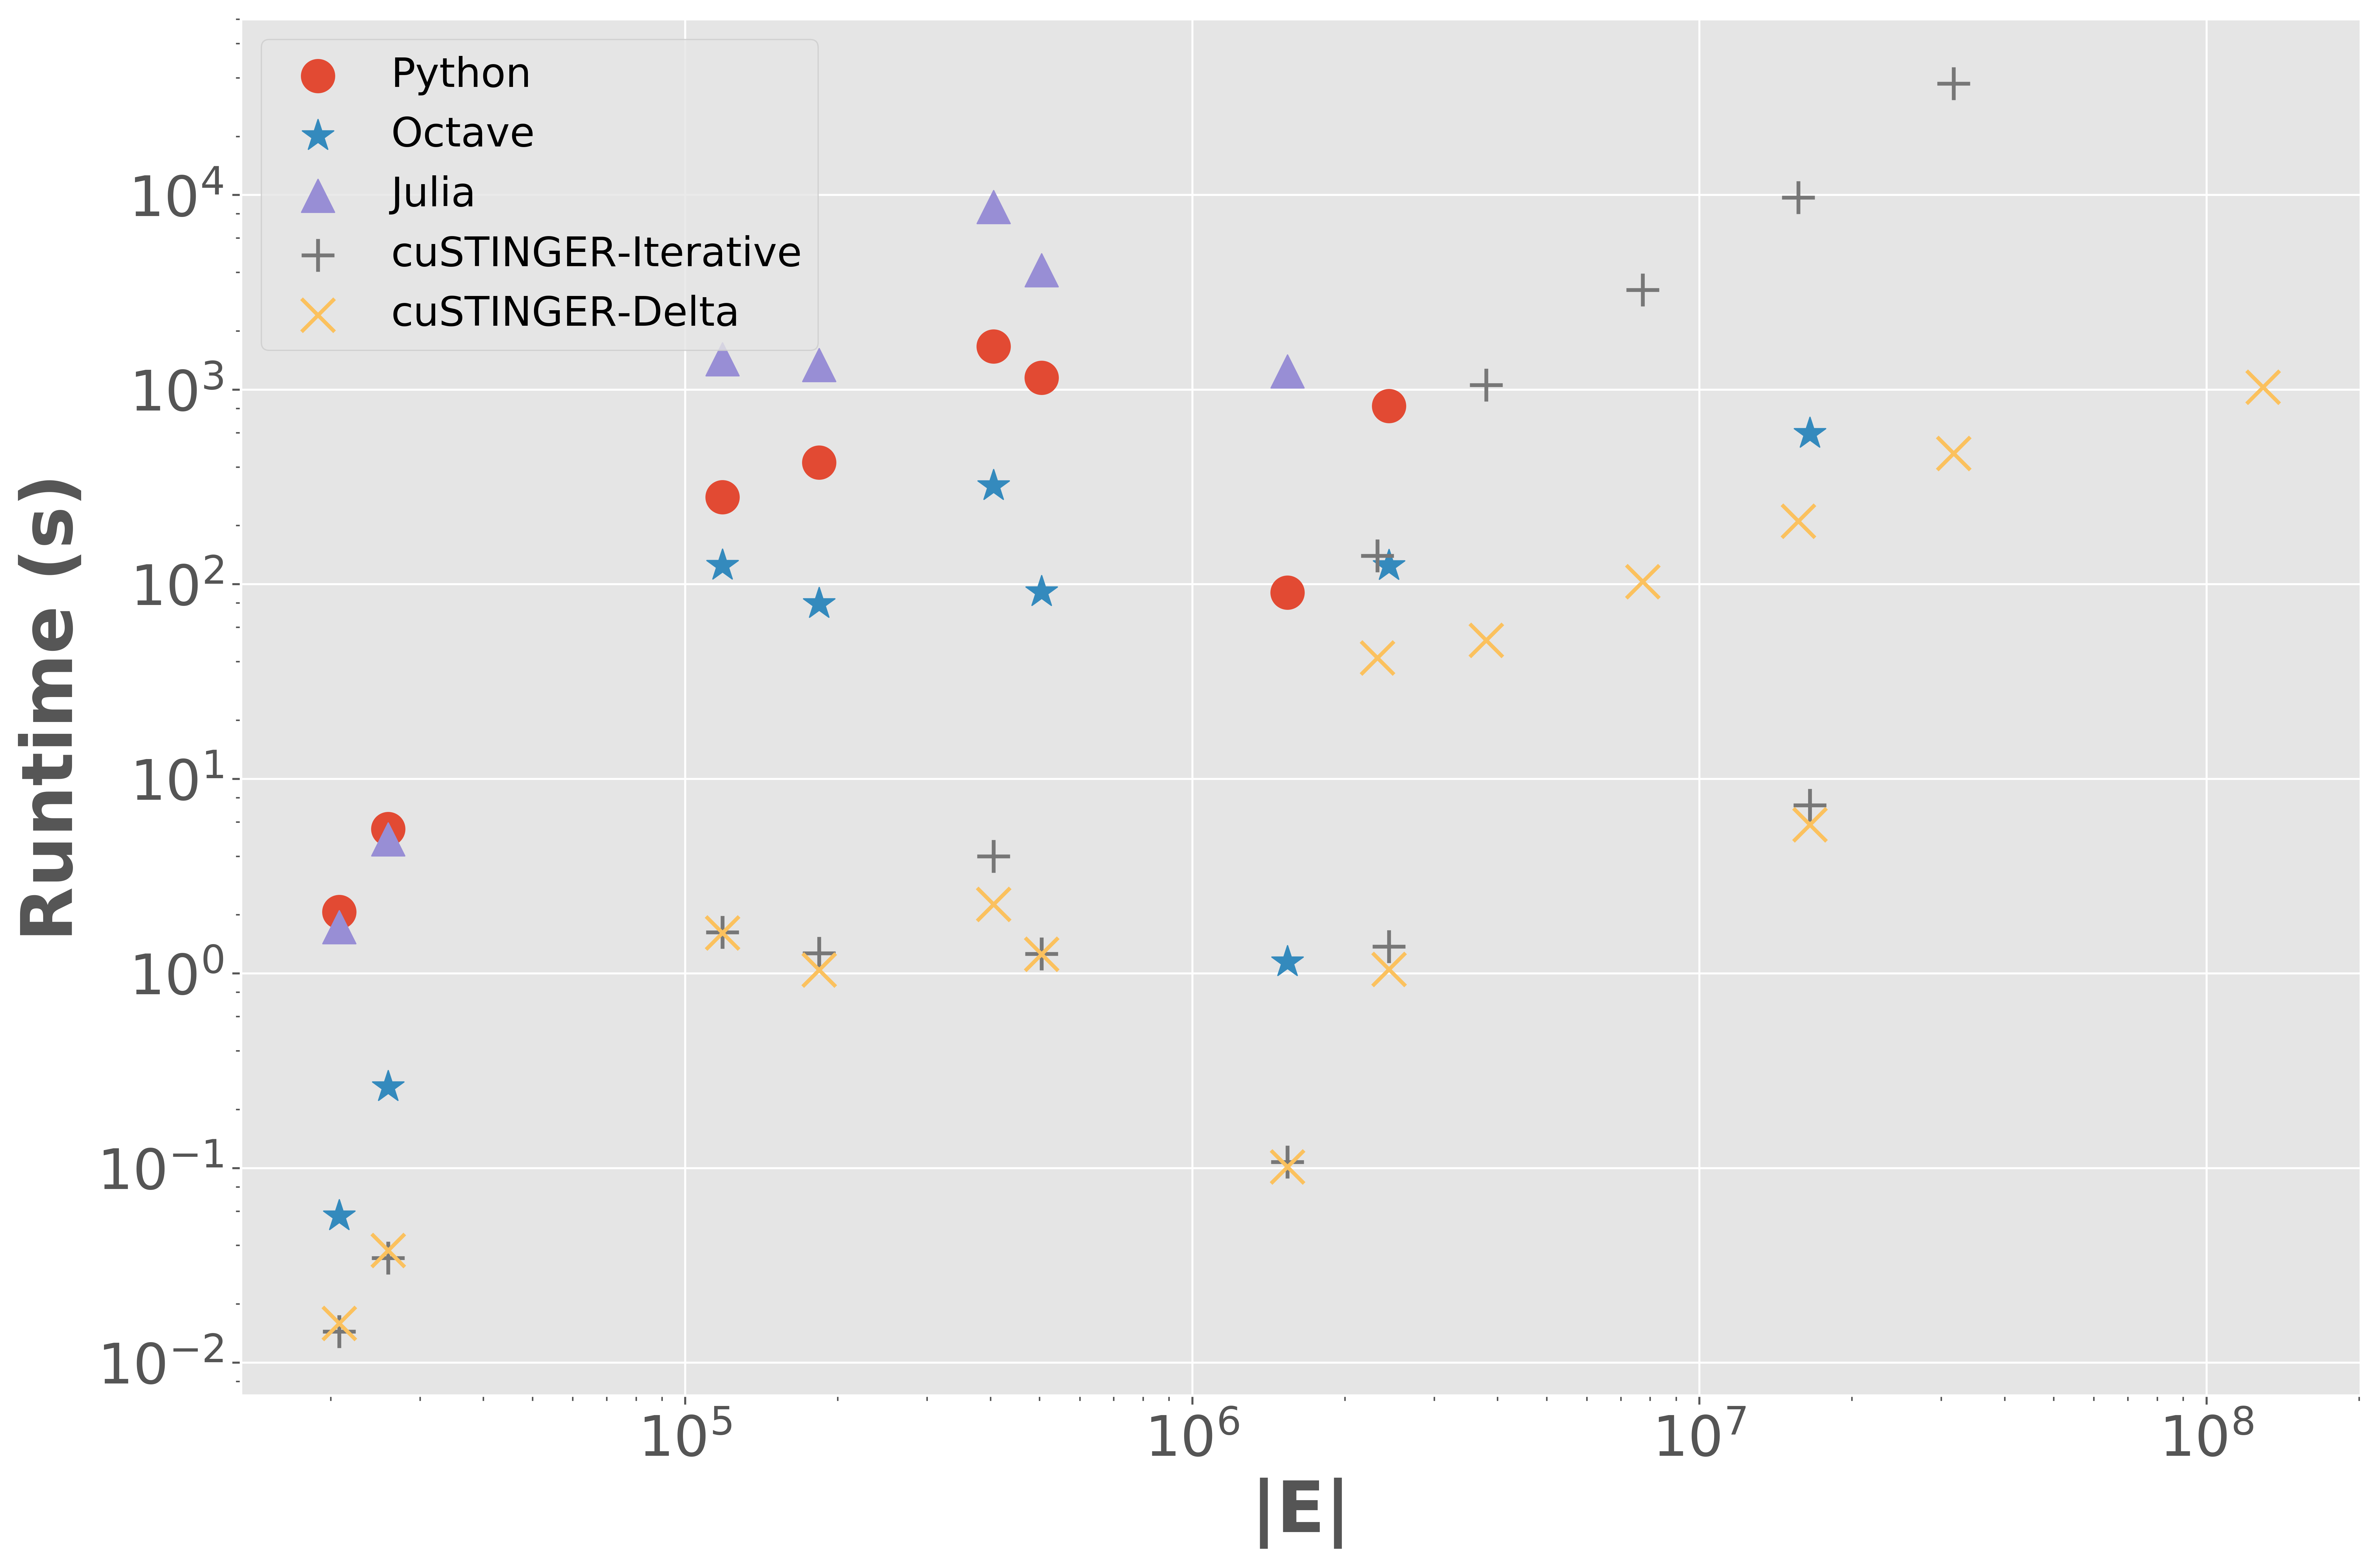

In [26]:
results = ["../results/python-maxk-062717.out",
           "../results/matlab-maxk-062717.out",
           "../results/julia-maxk-062717.out",
          "../results/custinger-static-maxk-062717.out",
          "../results/custinger-dynamic-maxk-062717.out"]
benchmarks = ["Python", "Octave", "Julia", CUS1, CUS2]
# title = "Max-k Runtime Comparison"
saveTo = "../analysis/maxk-scatter-final.pdf"
plotKCompareScatter(results, benchmarks, GRAPHS, savePath=saveTo)

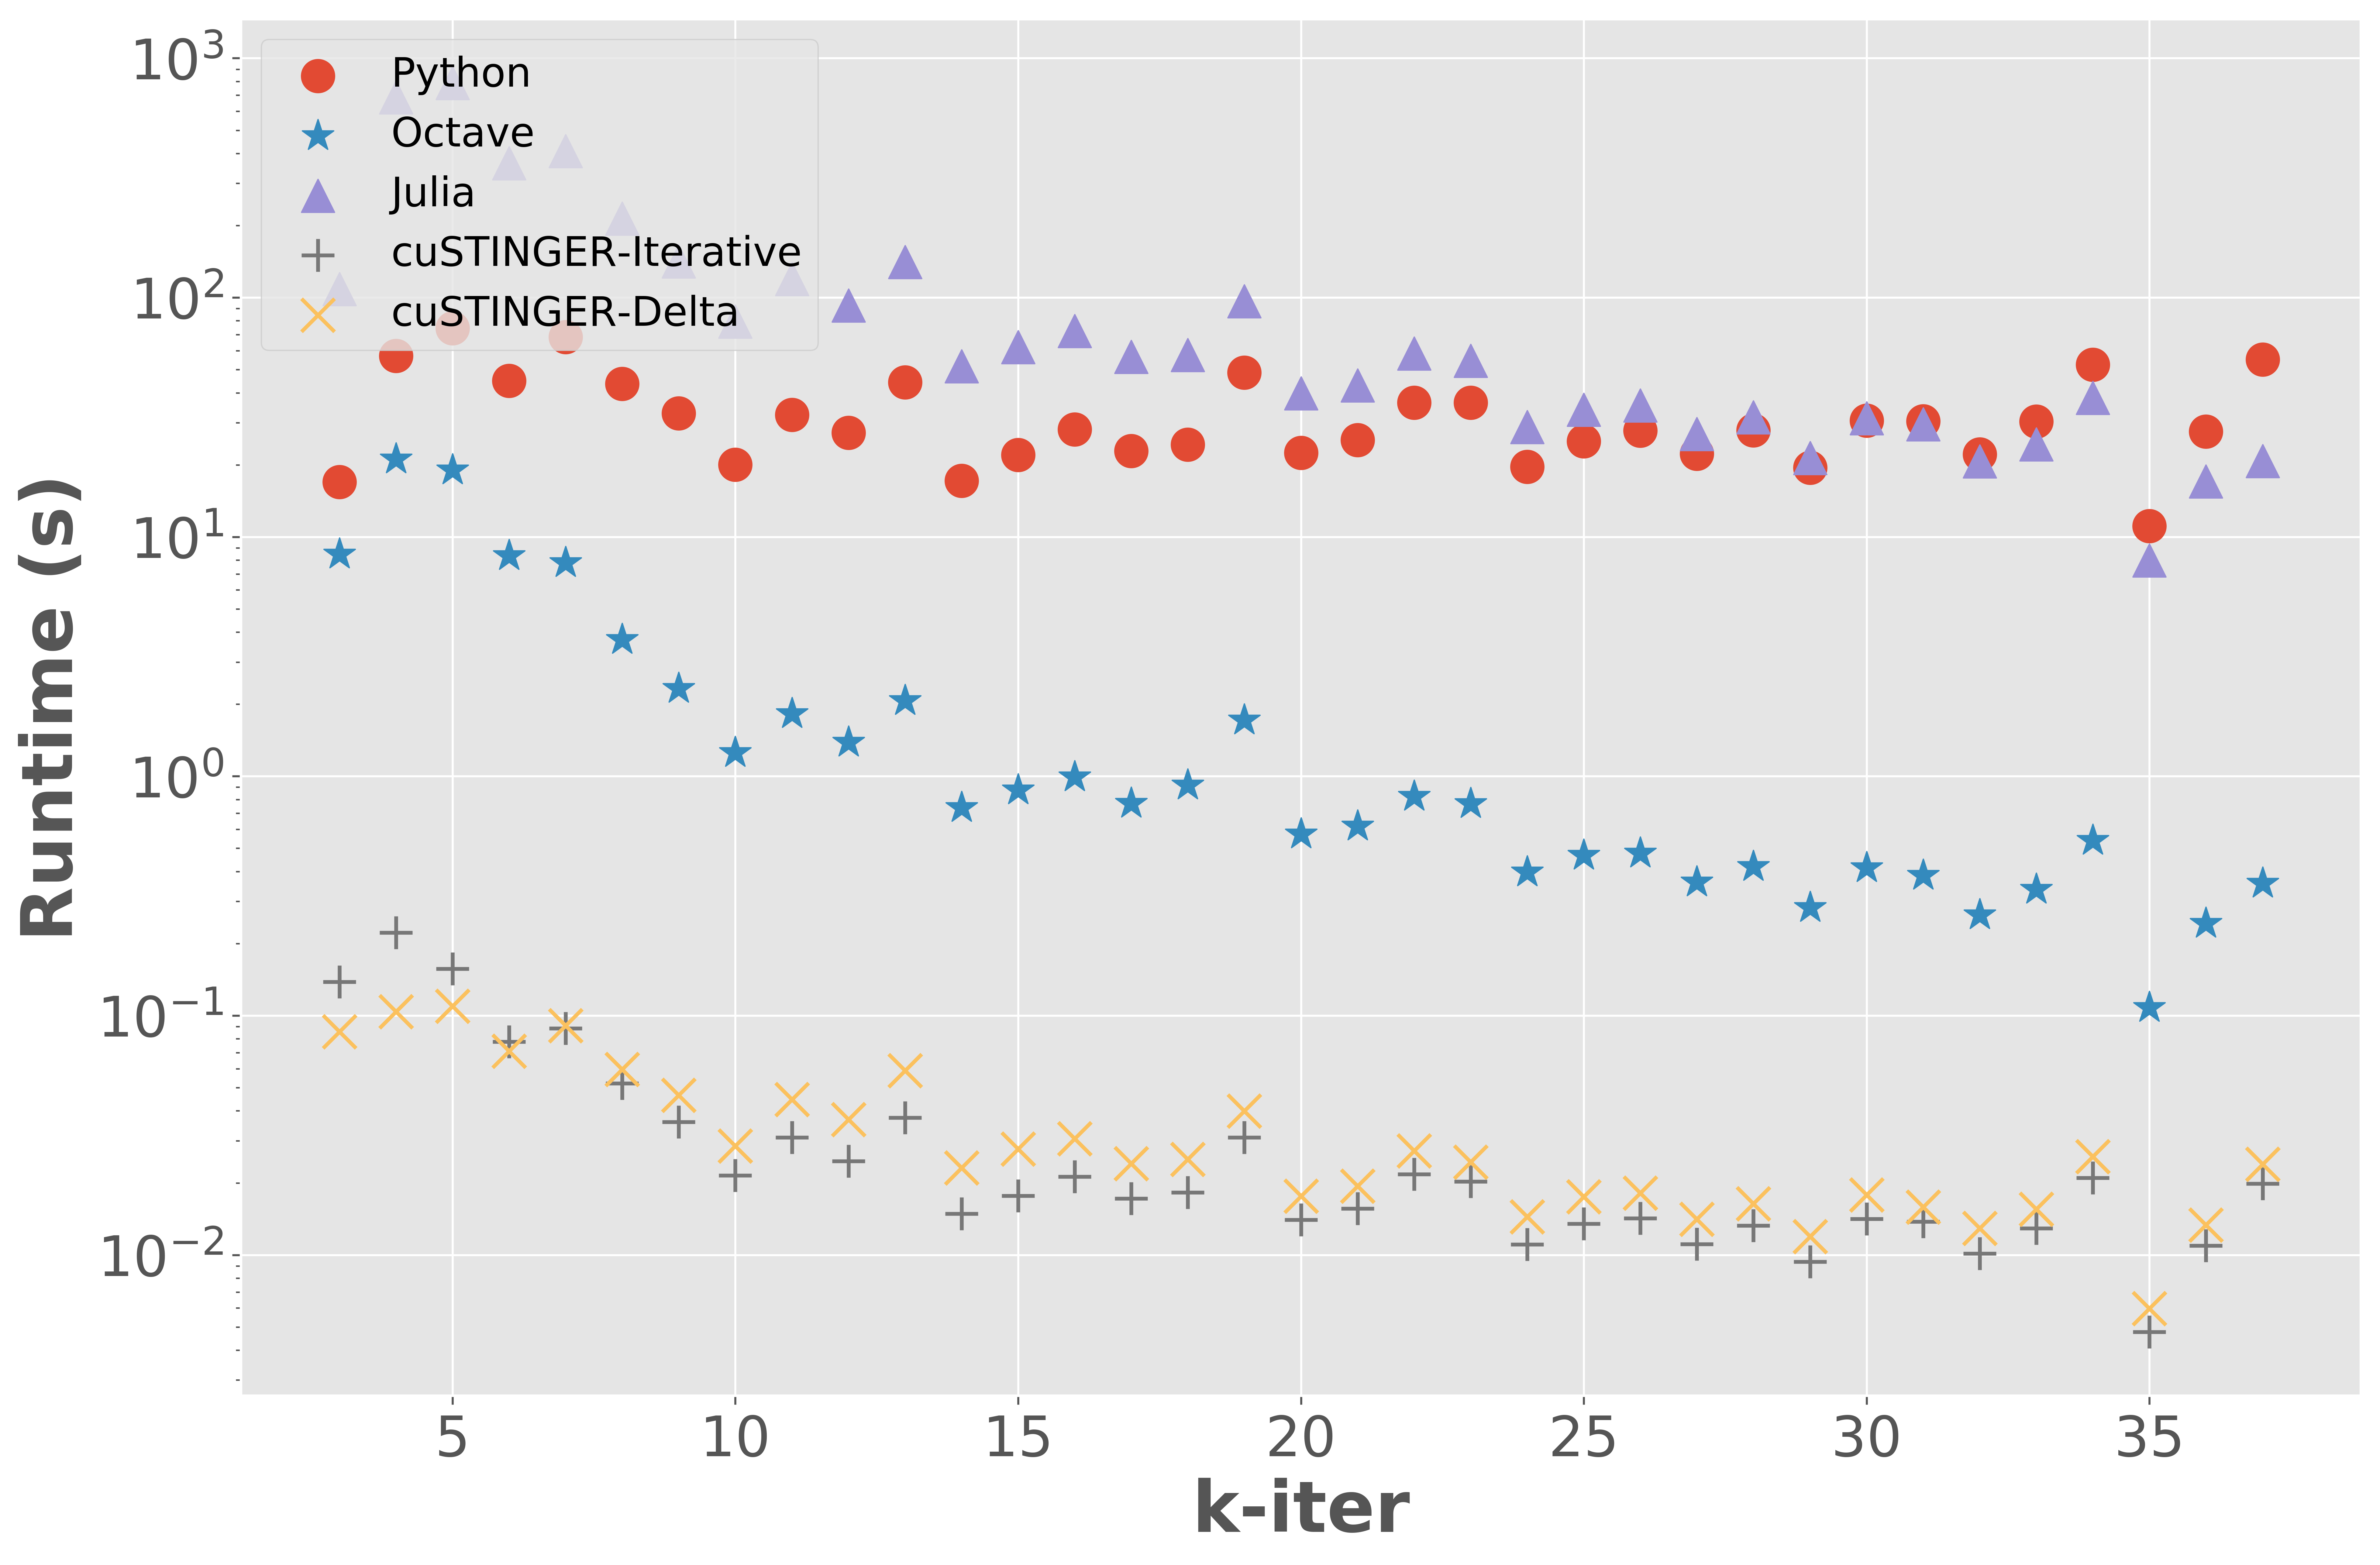

In [27]:
results = ["../results/python-maxk-062717.out",
           "../results/matlab-maxk-062717.out",
           "../results/julia-maxk-062717.out",
           "../results/custinger-static-maxk-062717.out", 
          "../results/custinger-dynamic-maxk-062717.out"]
benchmarks = ["Python", "Octave", "Julia", CUS1, CUS2]
graph = "soc-Slashdot0902"
saveTo = "../analysis/slashdot-kIter-scatter-final.pdf"
plotKIterScatter(results, benchmarks, graph, savePath=saveTo)

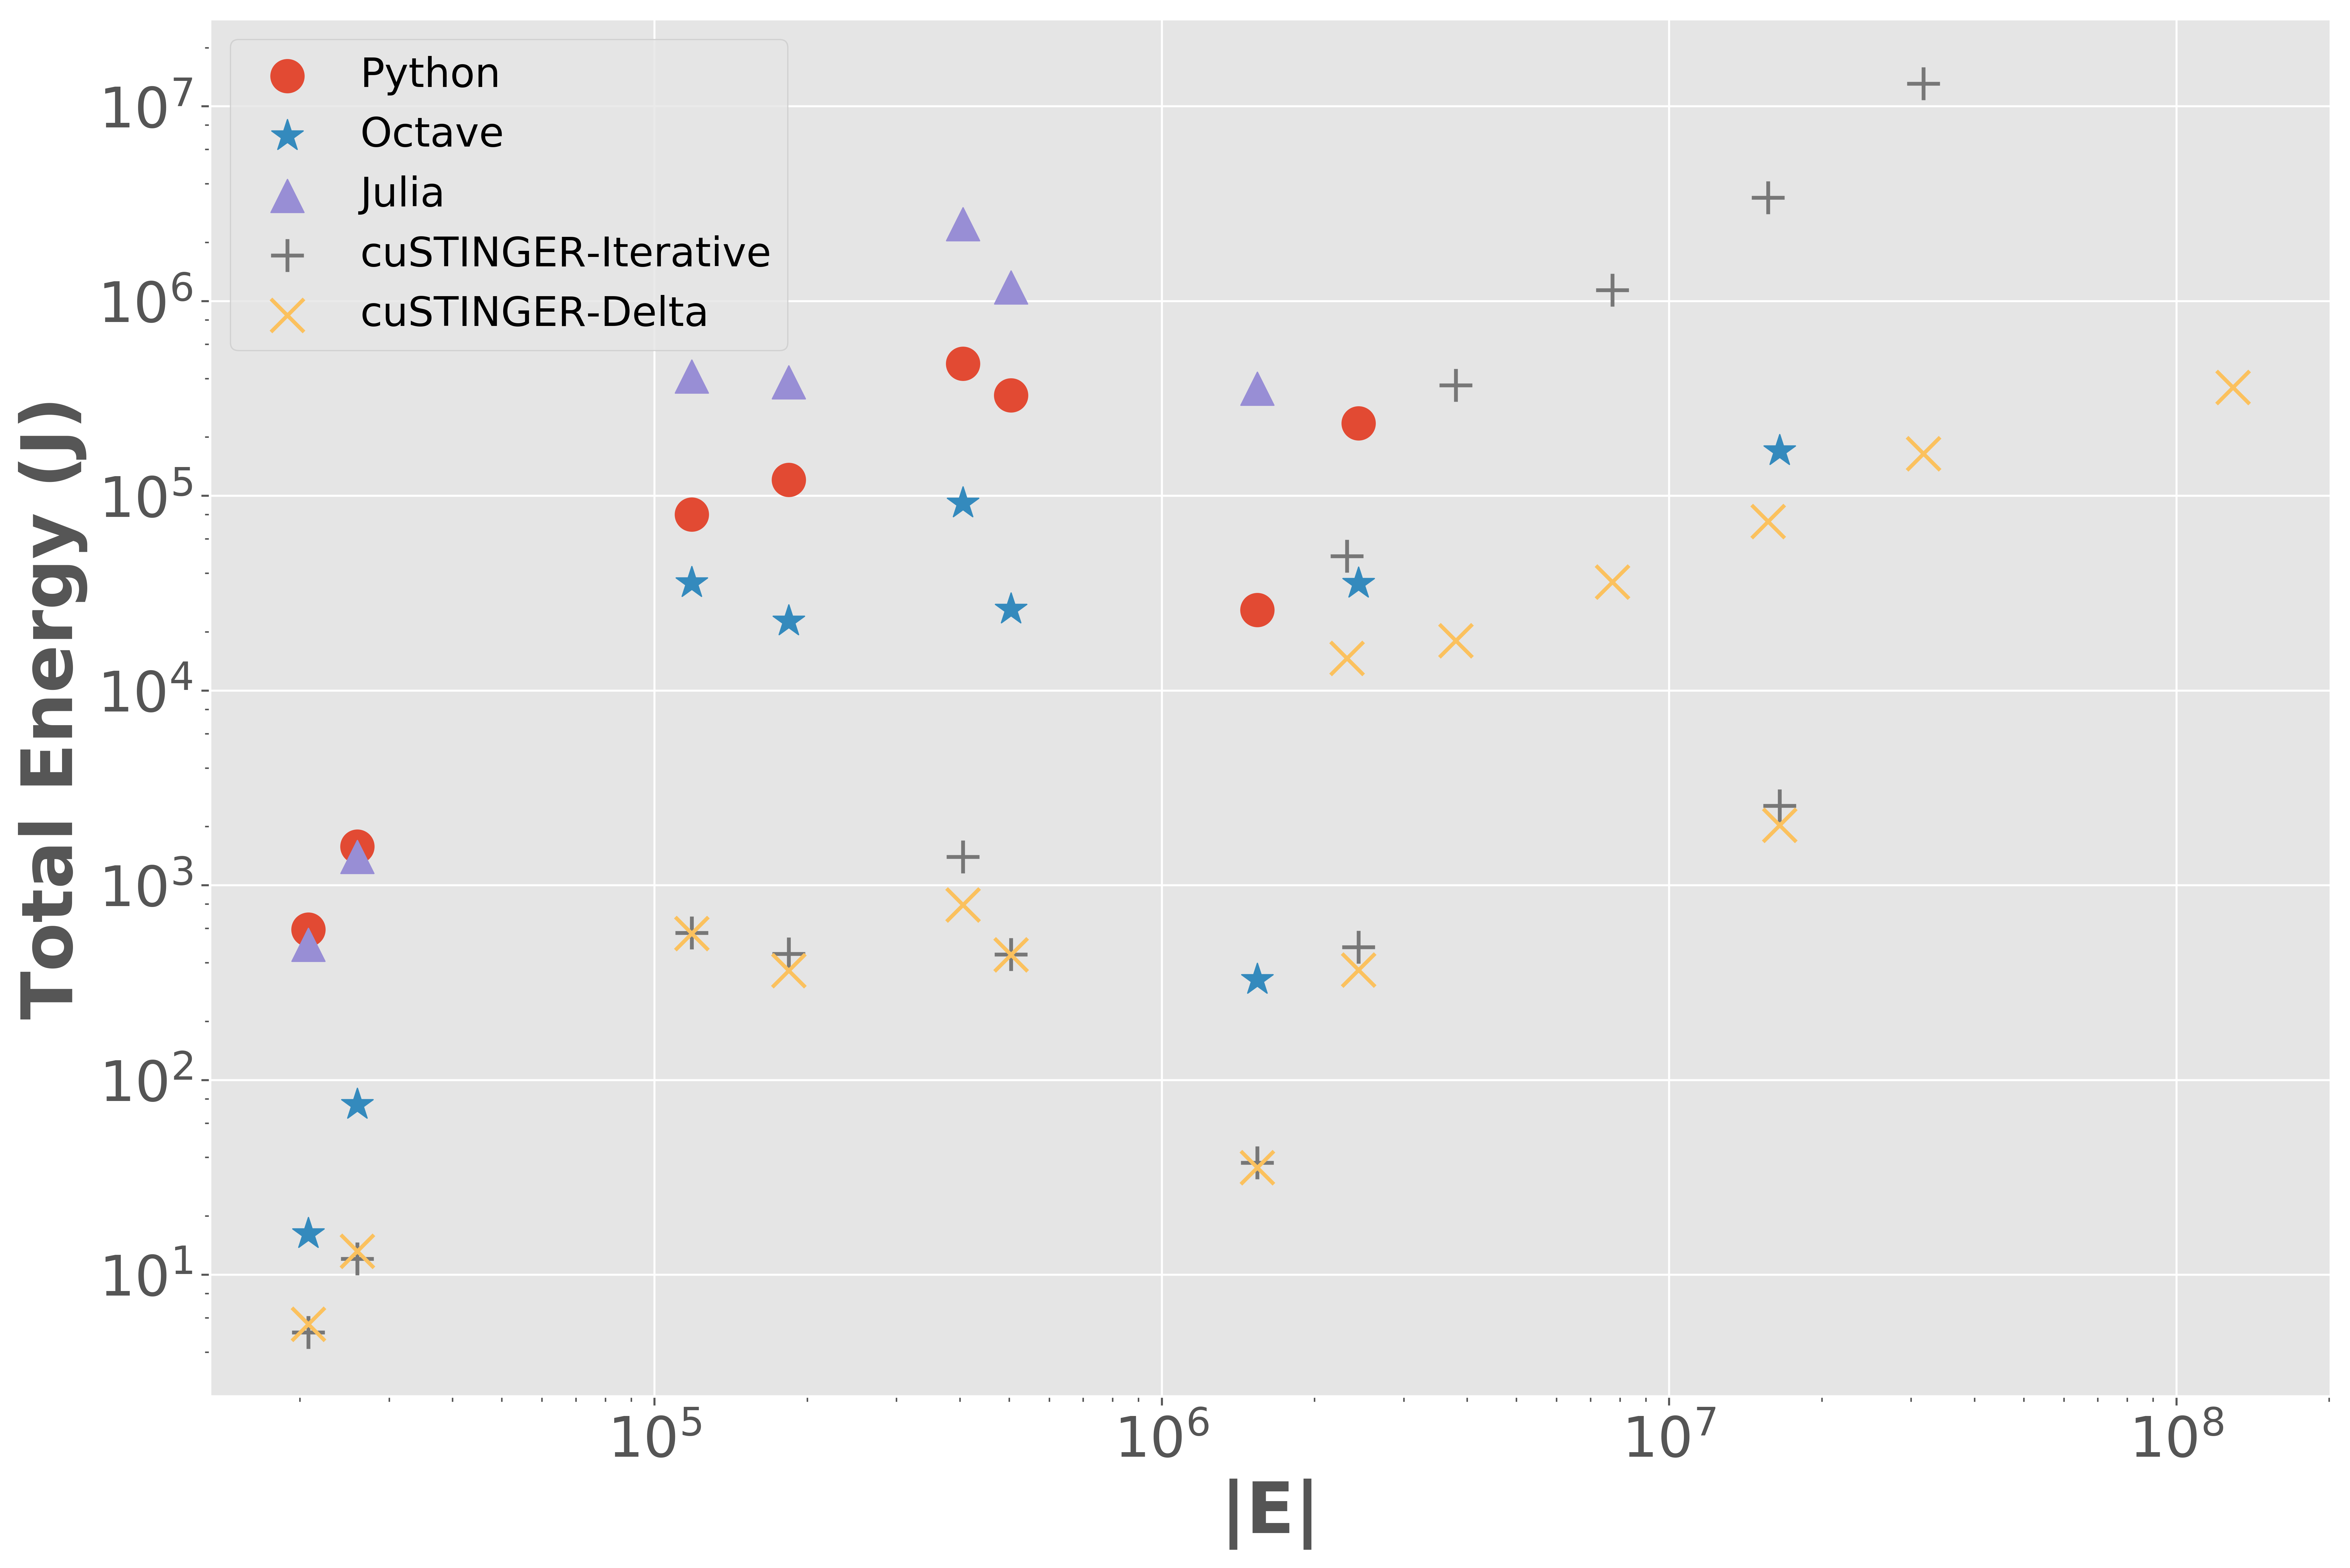

In [29]:
results = ["../results/python-maxk-062717.out",
           "../results/matlab-maxk-062717.out",
           "../results/julia-maxk-062717.out",
          "../results/custinger-static-maxk-062717.out",
          "../results/custinger-dynamic-maxk-062717.out"]
benchmarks = ["Python", "Octave", "Julia", CUS1, CUS2]
saveTo = "../analysis/maxk-energy-final.pdf"
plotKCompareEnergy(results, benchmarks, GRAPHS, savePath=saveTo)